# Churn Prediction

In this notebook we will be looking at two examples of customer churn prediction in the telecom industry. In each case we will build a machine learning model which will predict if a customer churns or not churn. In AI terminology, this is a binary classification problem. 

## Setup environment

As usual, we begin by importing libraries. 

In [1]:
# Shap explainability
!pip install shap

In [2]:
# The following two commands ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Libraries for data processing and manipulation
import numpy as np # Used for scientific computing and efficient multi dimensional array processing
import pandas as pd # Used for data analysis and manipulation - data frames

# Modelling utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

# For Modelling
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import neighbors
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Explainability and visualisation libraries
from xgboost import plot_tree
from prettytable import PrettyTable
import shap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

## Download datasets

For convenience, we have hosted the two datasets on a Google drive, we need to complete the familiar authentication step.  

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# These are the file IDs of the data sets

#dataset_one_file_id = '1Ob37XL2aCU9FgX6czALtIibVKGZ0zjqR'
dataset_one_file_id ='1t_Afmfz9xwrJc-QkjXYF4Fmddc66r6QO'
#dataset_two_file_id = '1oYAyQ340eo6xcJ-tniS83QzL1wXvLSUN'

# Download the file from Google Drive
downloaded = drive.CreateFile({'id':dataset_one_file_id})
downloaded.GetContentFile('bank-term-deposit.csv')

#downloaded_second = drive.CreateFile({'id':dataset_two_file_id})
#downloaded_second.GetContentFile('churn_dataset_two.csv')

## Churn model 01

Let's build the first model for the churn dataset provided by IBM, each row represents a unique costumer, while the columns contains representative information about subscribed services, account details and demographics.

https://www.kaggle.com/blastchar/telco-customer-churn

### Load dataset


In [4]:
# Read the first data set to a pandas dataframe
df_first_churn = pd.read_csv("bank-term-deposit.csv")
# find out the dimensionality of the dataframe i.e. (rows, columns) 
print(df_first_churn.shape)
# extract the top 3 rows of the dataframe
df_first_churn.head(3)

(41188, 21)


age        job  marital  ... euribor3m nr.employed   y
0   56  housemaid  married  ...     4.857      5191.0  no
1   57   services  married  ...     4.857      5191.0  no
2   37   services  married  ...     4.857      5191.0  no

[3 rows x 21 columns]

### Impute missing values

In [5]:
# trim any whitespace in the dataframe using a lambda function to take each element which is a string and strip out any leading trailing spaces.
df_first_churn = df_first_churn.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
# replace any blanks with NaN for consistency.
df_first_churn.replace('', np.NaN, inplace=True)
# use the isna() function to find and sum all the blank rows by each column of the dataframe.
print(df_first_churn.isna().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


There are 11 missing values in the *TotalCharges* column. In this case, we follow common intuition as the imputation method - the missing values indicate that the customer never paid any charges so we replace with 0.

In [ ]:
df_first_churn['TotalCharges'] = df_first_churn['TotalCharges'].fillna(0).astype('float32')

### Data Exploration

#### Target variable

Visualise the distribution of the target variable i.e. *Churn* this is a binary value. Here we can already see this is an imbalanced dataset. 

In [6]:
df_first_churn['y'].value_counts(normalize=True) * 100

no     88.734583
yes    11.265417
Name: y, dtype: float64

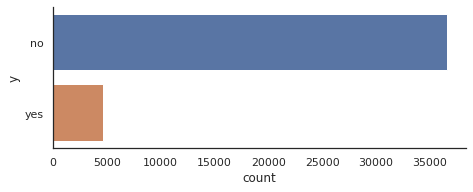

In [7]:
ax = sns.catplot(y="y", kind="count", data=df_first_churn, height=2.6, aspect=2.5, orient='h')

#### Analysis of Numerical Inputs

For numerical input variables tenure, monthly charges and total charges, let's plot the probability density distribution for some indications of churn and non-churn. Think of the kdeplot as a histogram for continuous numerical values. 

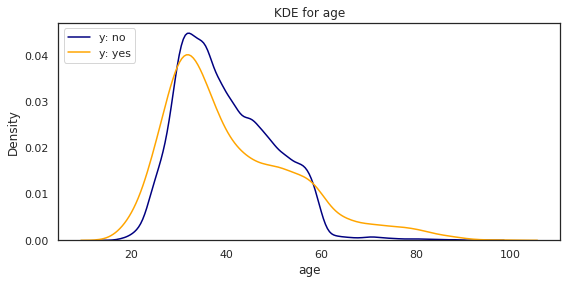

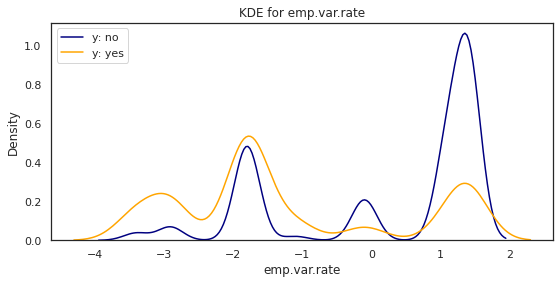

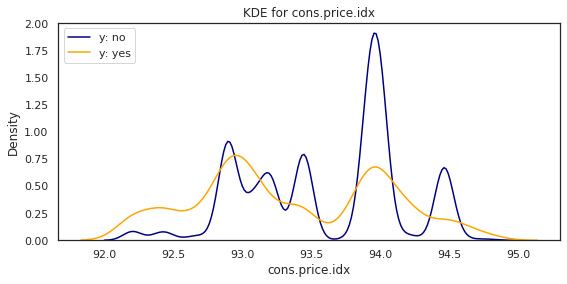

In [ ]:
# here we create a function as we have to plot three graphs in the same format. 
def kdeplot(features):
    for feature in features:
      plt.figure(figsize=(9, 4))
      plt.title("KDE for {}".format(feature))
      ax0 = sns.kdeplot(df_first_churn[df_first_churn['y'] == 'no'][feature].dropna(), color= 'navy', label= 'y: no')
      ax1 = sns.kdeplot(df_first_churn[df_first_churn['y'] == 'yes'][feature].dropna(), color= 'orange', label= 'y: yes')
      plt.legend(loc="upper left")

columns = ['age', 'emp.var.rate', 'cons.price.idx']
kdeplot(columns)

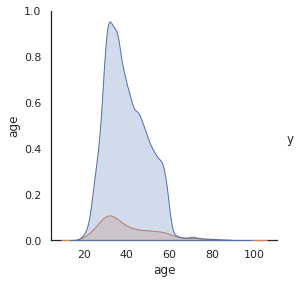

In [ ]:
sns.pairplot(df_first_churn[['y', 'age', 'job']], hue="y", height=4)

What are our preliminary insights? 

* Tenure - recent customers are more likely to churn
* MonthlyCharges - Customers with high charges are more likely to churn
* TotalCharges - indistinguishable 

#### Analysis of Categorical Inputs

We have 16 categorical inputs: 

* Six binary - Yes/No
* Nine inputs with three unique values each
* One input with four unique values

##### Demographic

In [ ]:
def plot_categorical_features(features, title):
  fig, axs = plt.subplots(ncols=2,
                          nrows=int(len(features) / 2) + len(features) % 2)
  fig.set_size_inches(20, 10)

  row = col = 0

  for feature in features:
    plot_title = '{} - {}'.format(title, feature)
    sns.countplot(x=feature, hue="y", data=df_first_churn, ax=axs[row][col]).set_title(plot_title)

    if col == 1:
      col = 0
      row += 1
    else:
      col += 1

  plt.tight_layout()

In [ ]:
plot_categorical_features(['gender', 'SeniorCitizen', 'Partner', 'Dependents'], 'Demographic View')

*   Drawing from the visualisations there doesn't seem to be any variance between the churn of male and female customers.
*   However there a higher proportion of churn amongst SeniorCitizen, customers with no Partners and customers with no dependents.

##### Billing Preferences

In [ ]:
plot_categorical_features(['Contract', 'PaperlessBilling', 'PaymentMethod'], 'Billing Preferences')

*   Those with shorter plans (tenure) see a higher rate of churn. 
*   Those who opt out of PaperlessBilling and those who pay by electronic check seem to churn more frequently.

##### Contract and Payment

Analyzing the churn rates based on contract with monthly charges may help to derive further insights.

In [ ]:
ax = sns.catplot(x="Contract", y="MonthlyCharges", hue="Churn", kind="box", data=df_first_churn, height=4.2, aspect=1.4)

In [ ]:
ax = sns.catplot(y="Churn", x="MonthlyCharges", row="PaymentMethod", kind="box", data=df_first_churn, height=1.5, aspect=4, orient='h')

Based on above visualizations

* Longer term contracts with higher monthly charges have high churning possibility
* Mailed checks have lower charges
* Wider gap for churn and non-churn customers in mail check payment method preferred customers

##### Service Preferences

ValueError: ignored

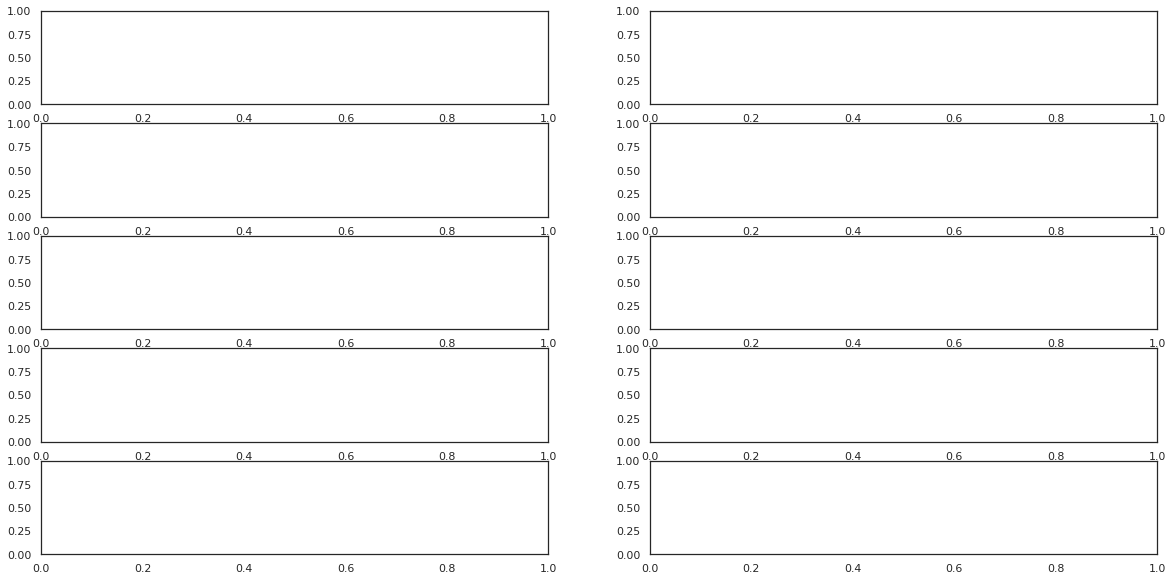

In [ ]:
plot_categorical_features(['PhoneService', 'MultipleLines', 'InternetService',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV','StreamingMovies'],
                   'Services Parameters')

### Data preprocessing

We will use one label encoding to handle categorical features which are based on strings.

In [9]:
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

df = df_first_churn.apply(lambda x: object_to_int(x))
df.head()

age  job  marital  education  ...  cons.conf.idx  euribor3m  nr.employed  y
0   56    3        1          0  ...          -36.4      4.857       5191.0  0
1   57    7        1          3  ...          -36.4      4.857       5191.0  0
2   37    7        1          3  ...          -36.4      4.857       5191.0  0
3   40    0        1          1  ...          -36.4      4.857       5191.0  0
4   56    7        1          3  ...          -36.4      4.857       5191.0  0

[5 rows x 21 columns]

### Creating training and testing datasets

In [10]:
df['log_value'] = np.log(df['campaign'])

df.head()

age  job  marital  education  ...  euribor3m  nr.employed  y  log_value
0   56    3        1          0  ...      4.857       5191.0  0        0.0
1   57    7        1          3  ...      4.857       5191.0  0        0.0
2   37    7        1          3  ...      4.857       5191.0  0        0.0
3   40    0        1          1  ...      4.857       5191.0  0        0.0
4   56    7        1          3  ...      4.857       5191.0  0        0.0

[5 rows x 22 columns]

In [11]:
df=pd.get_dummies(df)
df.head()

age  job  marital  education  ...  euribor3m  nr.employed  y  log_value
0   56    3        1          0  ...      4.857       5191.0  0        0.0
1   57    7        1          3  ...      4.857       5191.0  0        0.0
2   37    7        1          3  ...      4.857       5191.0  0        0.0
3   40    0        1          1  ...      4.857       5191.0  0        0.0
4   56    7        1          3  ...      4.857       5191.0  0        0.0

[5 rows x 22 columns]

In [12]:
# Separate input variables (X) from the target (y)
drop = ['duration', 'campaign','day','month','y']
X, y = df.drop(drop, axis=1, errors='ignore'), df['y']
X.head()

age  job  marital  ...  euribor3m  nr.employed  log_value
0   56    3        1  ...      4.857       5191.0        0.0
1   57    7        1  ...      4.857       5191.0        0.0
2   37    7        1  ...      4.857       5191.0        0.0
3   40    0        1  ...      4.857       5191.0        0.0
4   56    7        1  ...      4.857       5191.0        0.0

[5 rows x 18 columns]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 40)

### Building the models

We will use a random forest classifier to build a simple machine learning model to predict the customer churn.


In [14]:
# Fit RandomForest Classifier
rfChurn = RandomForestClassifier()
rfChurn.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
#Logistic regression 
churnLogReg = LogisticRegression()
# fit the model on the training data
churnLogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
#Decision tree 
churnDecisionTree = tree.DecisionTreeClassifier()
churnDecisionTree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [17]:
# K-nearest neighbour 
churnKNN = neighbors.KNeighborsClassifier()
churnKNN.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [18]:
# XGBoost 
churnXGB = xgb.XGBClassifier()
churnXGB.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [19]:
# Neural network - Multi-layer Perceptron
churnMLP = MLPClassifier()
churnMLP.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### Model Evaluation

In [20]:
classifiers = [ churnMLP, churnXGB, churnKNN, churnDecisionTree, churnLogReg]
evalTable = PrettyTable(['Name', 'Accuracy', 'F1-score', 'ROC AUC score', 'AP score'])
for i in classifiers:
  # Predict the class
  y_predict = i.predict(X_test)
  # Predict probabilities and retrieve just the probabilities for the positive class
  y_prob = i.predict_proba(X_test)[:, 1]
  evalTable.add_row( [ type(i).__name__, (round(i.score(X_test, y_test),3)), 
                      (round(metrics.f1_score(y_test, y_predict),3)), 
                      (round(metrics.roc_auc_score(y_test, y_prob),3)), 
                      (round(metrics.average_precision_score(y_test, y_prob),3)),] )

print(evalTable)

+------------------------+----------+----------+---------------+----------+
|          Name          | Accuracy | F1-score | ROC AUC score | AP score |
+------------------------+----------+----------+---------------+----------+
|     MLPClassifier      |  0.818   |  0.434   |     0.767     |  0.408   |
|     XGBClassifier      |  0.896   |  0.331   |     0.802     |  0.481   |
|  KNeighborsClassifier  |  0.885   |  0.347   |     0.716     |  0.305   |
| DecisionTreeClassifier |  0.842   |  0.344   |     0.634     |  0.198   |
|   LogisticRegression   |  0.895   |  0.292   |     0.753     |   0.42   |
+------------------------+----------+----------+---------------+----------+


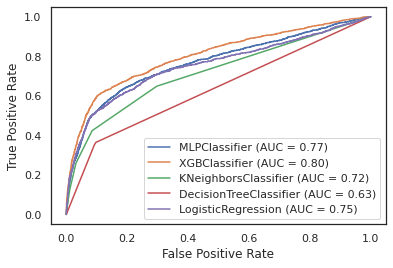

In [21]:
# All ROC curves
all_axes = plt.gca()
for i in classifiers:
    metrics.plot_roc_curve(i, X_test, y_test, ax=all_axes)

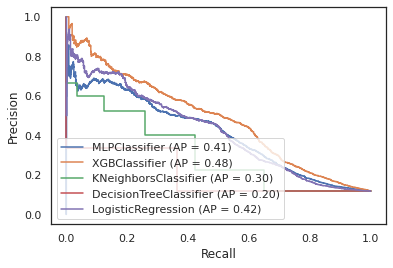

In [22]:
# All precision-recall curves
all_axes = plt.gca()
for i in classifiers:
    metrics.plot_precision_recall_curve(i, X_test, y_test, ax=all_axes)

In [23]:
lr_probs = rfChurn.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

# calculate accuracy metrices for random forest
lr_auc = roc_auc_score(y_test, lr_probs)
print('Accuracy=%.3f' % (accuracy_score(y_test, rfChurn.predict(X_test))))
print('ROC AUC=%.3f' % (lr_auc))
print('F1 Score=%.3f' % (f1_score(y_test, rfChurn.predict(X_test))))

Accuracy=0.890
ROC AUC=0.770
F1 Score=0.373


### Model Explainability



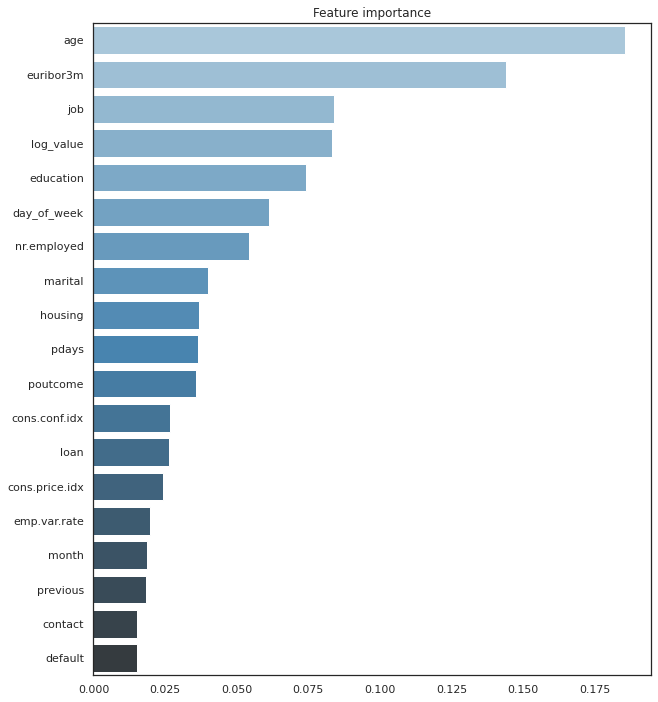

In [ ]:
# Plot features importances
imp = pd.Series(data=rfChurn.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

#### Summary plots
Summary plot of SHAP values indicate how each feature is important towards the target prediction.

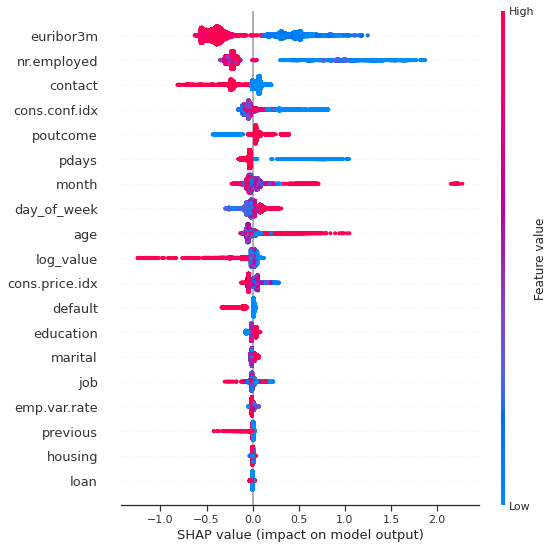

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(churnXGB)

# Calculate Shap values
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

#### Individual force plots

The individual force plot indicate how SHAP values impact for each of the prediction. Here we are selecting the first row which is the first day of the dataset to analyze how each feature impact towards the target prediction.


In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[2,:], X_train.iloc[2,:])

In [ ]:
print("Row values")
print(X_train.iloc[2,:])
print("Actual Value")
print(y_train.iloc[2])
print("Mean values")
X_train.mean()

Row values
age                 36.000000
job                  9.000000
marital              1.000000
education            3.000000
default              0.000000
housing              0.000000
loan                 0.000000
contact              0.000000
month                7.000000
day_of_week          3.000000
pdays              999.000000
previous             1.000000
poutcome             0.000000
emp.var.rate        -0.100000
cons.price.idx      93.200000
cons.conf.idx      -42.000000
euribor3m            4.153000
nr.employed       5195.800000
log_value            0.693147
Name: 24943, dtype: float64
Actual Value
0
Mean values


age                 40.026256
job                  3.739516
marital              1.172523
education            3.748639
default              0.207936
housing              1.070098
loan                 0.327356
contact              0.365926
month                4.222330
day_of_week          2.002046
pdays              962.289029
previous             0.170095
poutcome             0.932087
emp.var.rate         0.087583
cons.price.idx      93.578323
cons.conf.idx      -40.492581
euribor3m            3.625958
nr.employed       5167.185183
log_value            0.651914
dtype: float64

#### Decision Plot

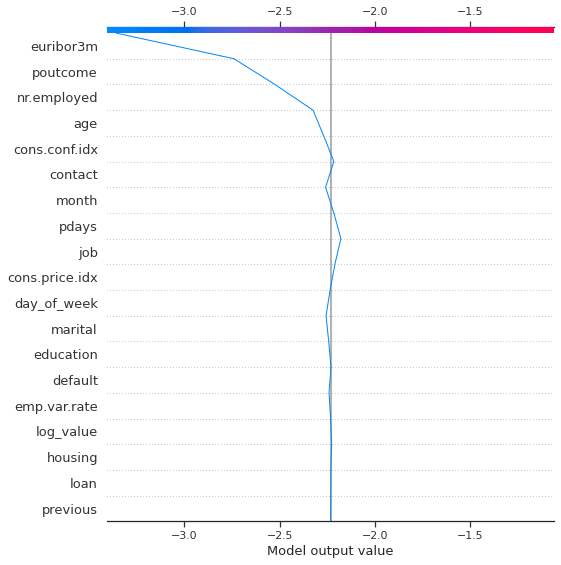

In [ ]:
shap.decision_plot(explainer.expected_value,
                   explainer.shap_values(X_train.iloc[2,:]),
                   feature_names=X_train.columns.tolist()
                   )

In [ ]:
y_train[0:10]

5960    0
4655    0
3525    1
3719    0
5260    0
2415    1
4117    0
2409    0
1611    0
6147    0
Name: Churn, dtype: int64

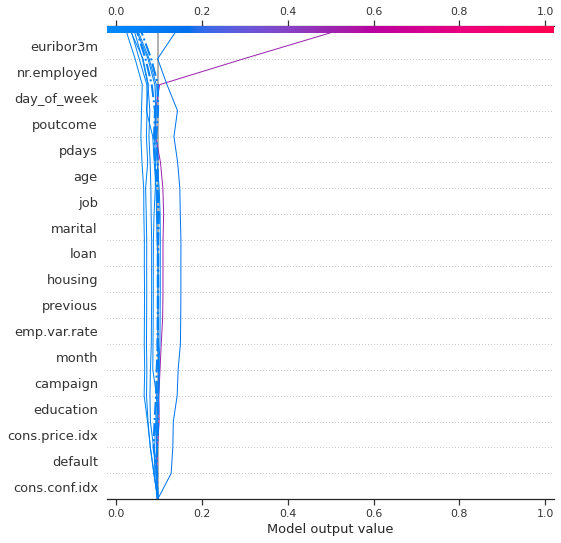

In [ ]:
shap.decision_plot(explainer.expected_value,
                   explainer.shap_values(X_test.iloc[0:10,:]),
                   feature_names=X_train.columns.tolist(),
                    highlight=[2,5],
                    feature_order='hclust',
                   link='logit'
                   )

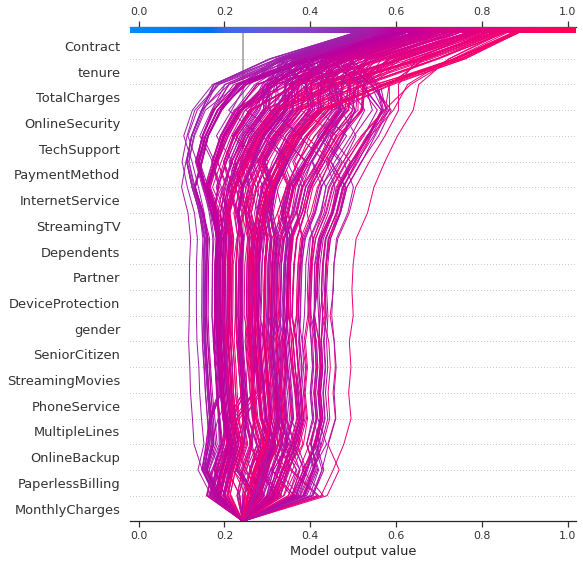

In [ ]:
y_pred = churnXGB.predict(X_test)
T = X_test[(X_test['Dependents'] == 0) & (X_test['Partner'] == 0) & (X_test['SeniorCitizen'] == 0) & (y_pred == 1)]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
shap.decision_plot(explainer.expected_value, sh, T, feature_order='hclust', link='logit') 

#### Dependence plots
The partial dependence plot shows the marginal effect of one or two variables towards the predicted outcome. It indicate the relationship between the target and the variable whether its linear, monotonic, or more complex.

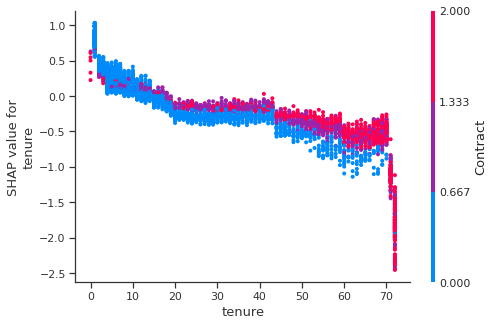

In [ ]:
shap.dependence_plot("tenure", shap_values, X_train)

#### Collective force plot

The collective force plot shows show all the features that contribute toward the target prediction. This is the individual force plot stacked vertically across all the data points.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_train.iloc[:1000,:])

## Churn model 02

This dataset is from a 2020 Kaggle competition.

https://www.kaggle.com/c/customer-churn-prediction-2020

### Load the dataset

In [ ]:
# Read the second churn dataset to a pandas dataframe
df_second_churn = pd.read_csv("churn_dataset_two.csv")
print(df_first_churn.shape)
df_second_churn.head(3)

(7043, 21)


state  account_length  ... number_customer_service_calls churn
0    OH             107  ...                             1    no
1    NJ             137  ...                             0    no
2    OH              84  ...                             2    no

[3 rows x 20 columns]

### Data Exploration

#### Target variable</h3>

In this churn study, we explore and predict whether client left the company in the previous month. Hence this simulate a binary classification problem. Here we analyse the data distribution for churn and non-churn customers.


In [ ]:
df_first_churn['Churn'].value_counts(normalize=True)


No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

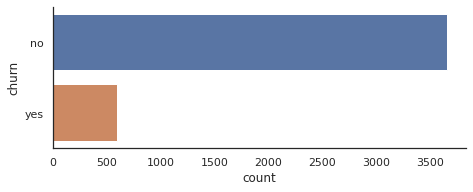

In [ ]:
ax = sns.catplot(y="churn", kind="count", data=df_second_churn, height=2.6, aspect=2.5, orient='h')

#### Numerical Inputs

There are several numerical columns in the dataset. The probability density distribution graph given below provide insights on how distribute with regards to churn across each feature range. 

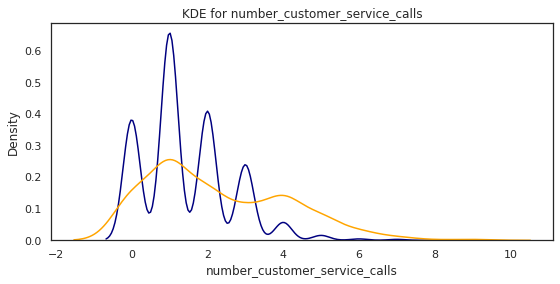

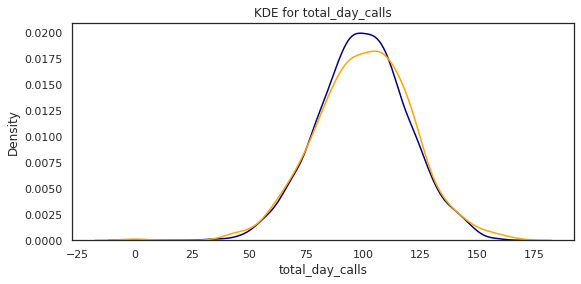

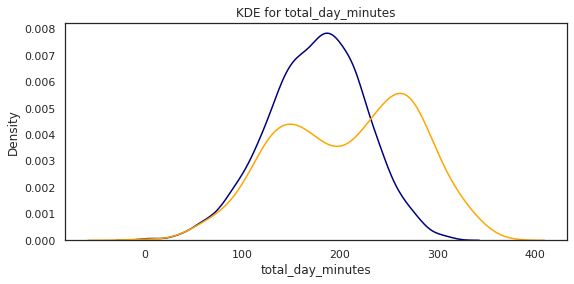

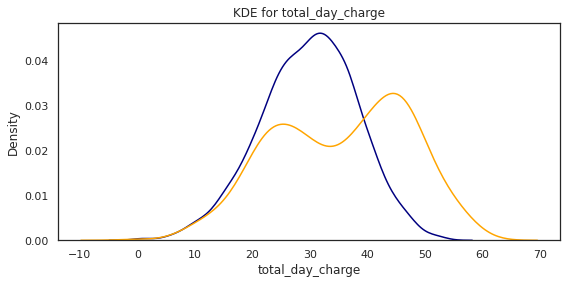

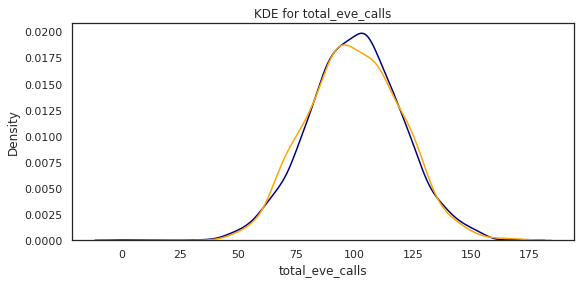

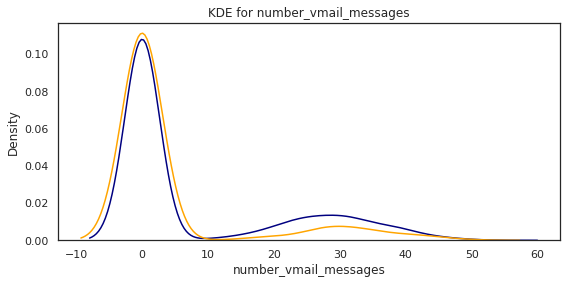

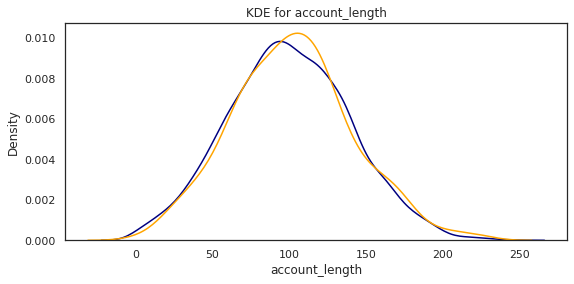

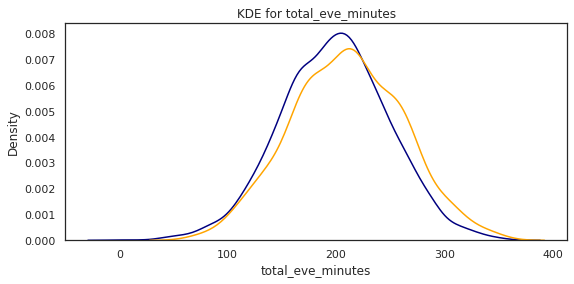

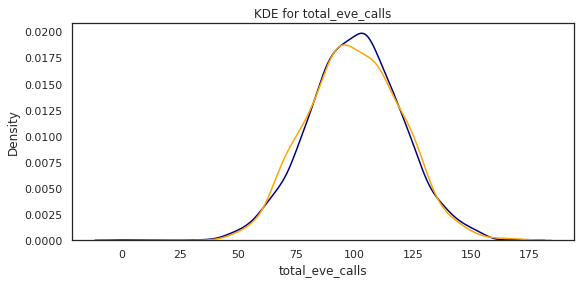

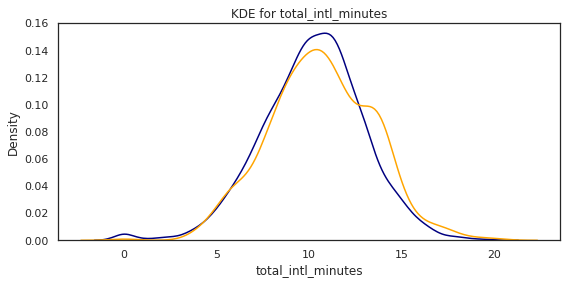

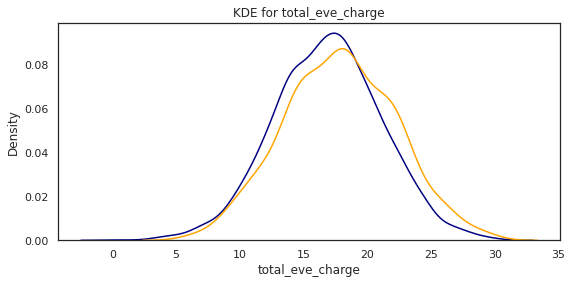

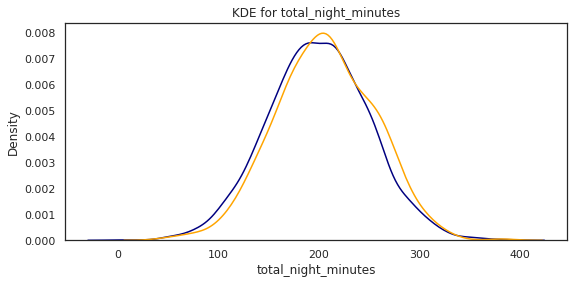

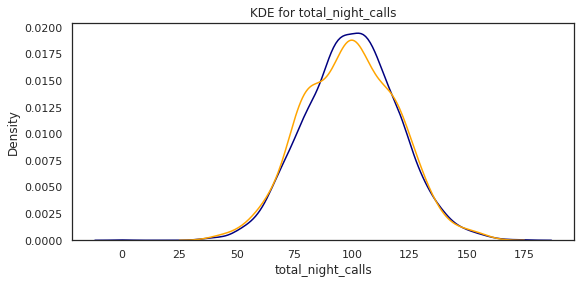

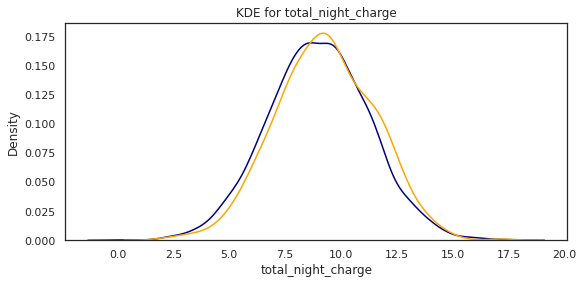

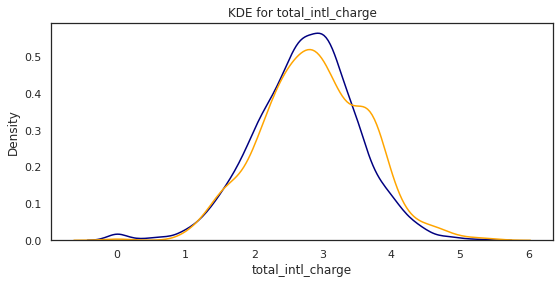

In [ ]:
def kdeplot_second_churn(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df_second_churn[df_second_churn['churn'] == 'no'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df_second_churn[df_second_churn['churn'] == 'yes'][feature].dropna(), color= 'orange', label= 'Churn: Yes')

kdeplot_second_churn('number_customer_service_calls')
kdeplot_second_churn('total_day_calls')
kdeplot_second_churn('total_day_minutes')
kdeplot_second_churn('total_day_charge')
kdeplot_second_churn('total_eve_calls')
kdeplot_second_churn('number_vmail_messages')
kdeplot_second_churn('account_length')
kdeplot_second_churn('total_eve_minutes')
kdeplot_second_churn('total_eve_calls')
kdeplot_second_churn('total_intl_minutes')
kdeplot_second_churn('total_eve_charge')
kdeplot_second_churn('total_night_minutes')
kdeplot_second_churn('total_night_calls')
kdeplot_second_churn('total_night_charge')
kdeplot_second_churn('total_intl_charge')

Based on above visualizations

*   A high number of customer calls and higher day charges have resulted in  higher rates of churn

#### Correlation between features

Correlation graph provides overview of feature correlation which is useful to get more insights of feature dependencies. We have replace all categorical variables before plotting the correlation matrix.

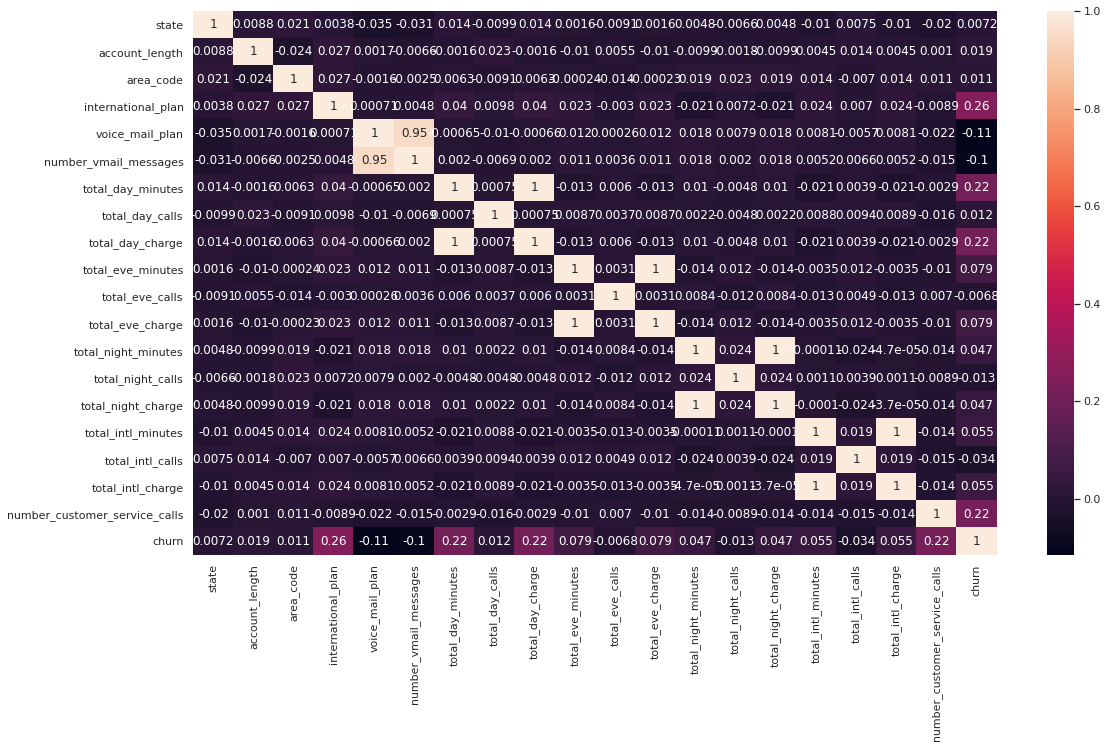

In [ ]:
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

df_second = df_second_churn.apply(lambda x: object_to_int(x))
df_second.head()

plt.figure(figsize = (18,10))
corr_matrix = df_second.corr()
sns.heatmap(corr_matrix, data = df_second_churn, annot=True)

### Splitting the dataset

In [ ]:
# Drop columns that are not required to include in the training data
drop = ['state','churn']
X, y = df_second.drop(drop, axis=1), df_second['churn']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 40)

### Building the models



In [ ]:
# params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 120, 'max_depth': 8}
# Fit RandomForest Classifier
rfChurn = RandomForestClassifier() 
rfChurn = rfChurn.fit(X_train, y_train)

In [ ]:
#Logistic regression 
churnLogReg = LogisticRegression()
#fit the model on the training data
churnLogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Decision tree 
churnDecisionTree = tree.DecisionTreeClassifier()
churnDecisionTree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# K-nearest neighbour 
churnKNN = neighbors.KNeighborsClassifier()
churnKNN.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# XGBoost 
churnXGB = xgb.XGBClassifier()
churnXGB.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Neural network - Multi-layer Perceptron
churnMLP = MLPClassifier()
churnMLP.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### Model Evaluation


In [ ]:
classifiers = [ churnMLP, churnXGB, churnKNN, churnDecisionTree, churnLogReg]
evalTable = PrettyTable(['Name', 'Accuracy', 'F1-score', 'ROC AUC score', 'AP score'])
for i in classifiers:
  # Predict the class
  y_predict = i.predict(X_test)
  # Predict probabilities and retrieve just the probabilities for the positive class
  y_prob = i.predict_proba(X_test)[:, 1]
  evalTable.add_row( [ type(i).__name__, (round(i.score(X_test, y_test),3)), 
                      (round(metrics.f1_score(y_test, y_predict),3)), 
                      (round(metrics.roc_auc_score(y_test, y_prob),3)), 
                      (round(metrics.average_precision_score(y_test, y_prob),3)),] )

print(evalTable)

+------------------------+----------+----------+---------------+----------+
|          Name          | Accuracy | F1-score | ROC AUC score | AP score |
+------------------------+----------+----------+---------------+----------+
|     MLPClassifier      |  0.878   |  0.424   |     0.815     |  0.503   |
|     XGBClassifier      |  0.952   |  0.797   |     0.935     |  0.869   |
|  KNeighborsClassifier  |  0.889   |  0.408   |     0.679     |  0.364   |
| DecisionTreeClassifier |  0.918   |  0.708   |     0.859     |  0.533   |
|   LogisticRegression   |  0.868   |  0.192   |     0.737     |  0.292   |
+------------------------+----------+----------+---------------+----------+


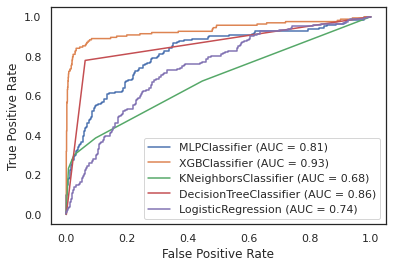

In [ ]:
# All ROC curves
all_axes = plt.gca()
for i in classifiers:
    metrics.plot_roc_curve(i, X_test, y_test, ax=all_axes)

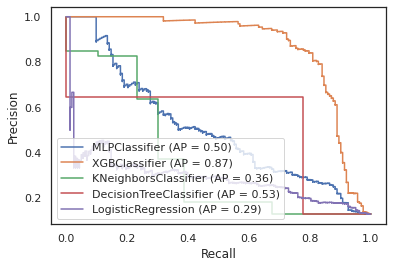

In [ ]:
# All precision-recall curves
all_axes = plt.gca()
for i in classifiers:
    metrics.plot_precision_recall_curve(i, X_test, y_test, ax=all_axes)

In [ ]:
lr_probs = rfChurn.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

# calculate accuracy metrices
lr_auc = roc_auc_score(y_test, lr_probs)
print('Accuracy=%.3f' % (accuracy_score(y_test, rfChurn.predict(X_test))))
print('ROC AUC=%.3f' % (lr_auc))
print('F1 Score=%.3f' % (f1_score(y_test, rfChurn.predict(X_test))))

Accuracy=0.961
ROC AUC=0.935
F1 Score=0.837


###  Model Explainability

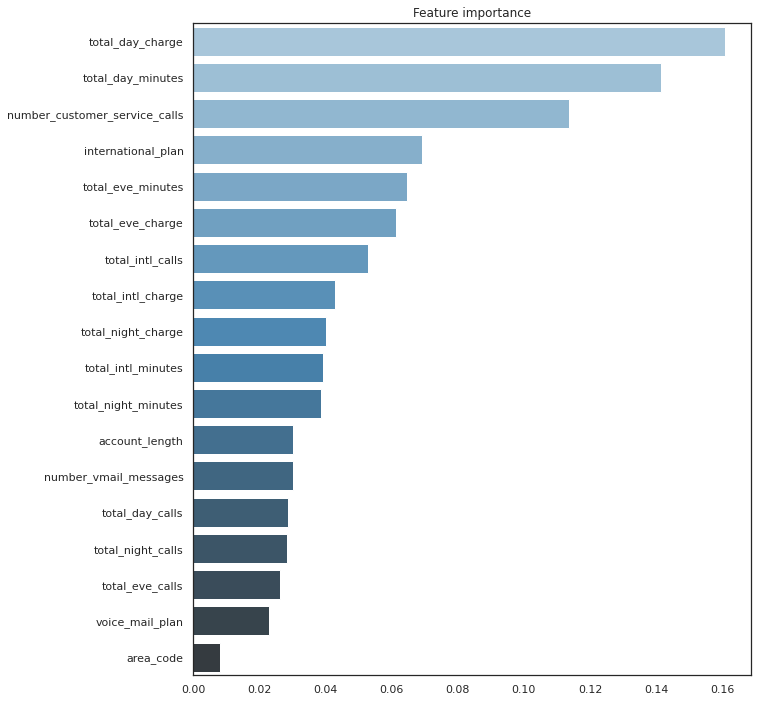

In [ ]:
# Plot features importances
imp = pd.Series(data=rfChurn.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

#### Summary plots
Summary plot of SHAP values indicate how each feature is important towards the target prediction.

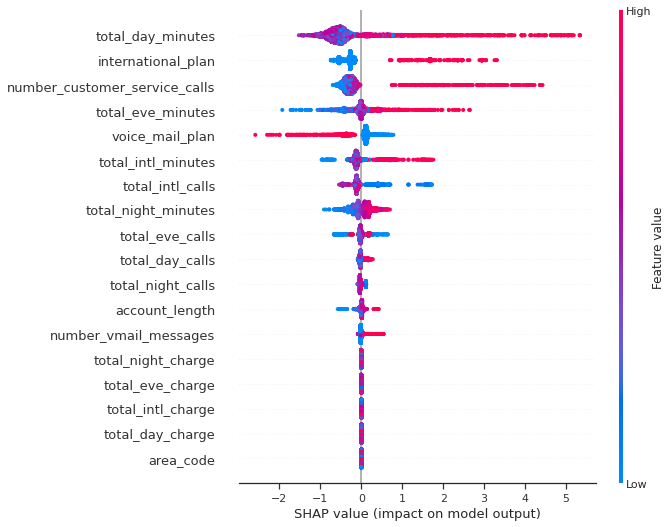

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(churnXGB)

# Calculate Shap values
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

In [ ]:
y_train[0:10]

2459    0
3767    0
3135    0
3028    0
1425    1
374     0
538     0
3690    1
3709    0
276     1
Name: churn, dtype: int64

In [ ]:
print("Row values")
print(X_train.iloc[4,:])
print("Actual Value")
print(y_train.iloc[4])
print("Mean values")
X_train.mean()

Row values
account_length                    79.00
area_code                          1.00
international_plan                 0.00
voice_mail_plan                    0.00
number_vmail_messages              0.00
total_day_minutes                268.30
total_day_calls                  114.00
total_day_charge                  45.61
total_eve_minutes                185.50
total_eve_calls                  111.00
total_eve_charge                  15.77
total_night_minutes              264.60
total_night_calls                 88.00
total_night_charge                11.91
total_intl_minutes                 6.30
total_intl_calls                   7.00
total_intl_charge                  1.70
number_customer_service_calls      1.00
Name: 1425, dtype: float64
Actual Value
1
Mean values


account_length                    99.996303
area_code                          0.988908
international_plan                 0.089748
voice_mail_plan                    0.264874
number_vmail_messages              7.705210
total_day_minutes                179.866050
total_day_calls                   99.827563
total_day_charge                  30.577748
total_eve_minutes                200.906050
total_eve_calls                  100.181849
total_eve_charge                  17.077234
total_night_minutes              202.274118
total_night_calls                 99.723697
total_night_charge                 9.102434
total_intl_minutes                10.238622
total_intl_calls                   4.429916
total_intl_charge                  2.764995
number_customer_service_calls      1.547563
dtype: float64

#### Decision Plot

Decision plots offer a detailed view of a model’s inner workings; that is, they show how models make decisions. [This article](https://towardsdatascience.com/introducing-shap-decision-plots-52ed3b4a1cba) offers a good intuitive explanation of how decision plots work. More information can be found in [this wiki](https://slundberg.github.io/shap/notebooks/plots/decision_plot.html).

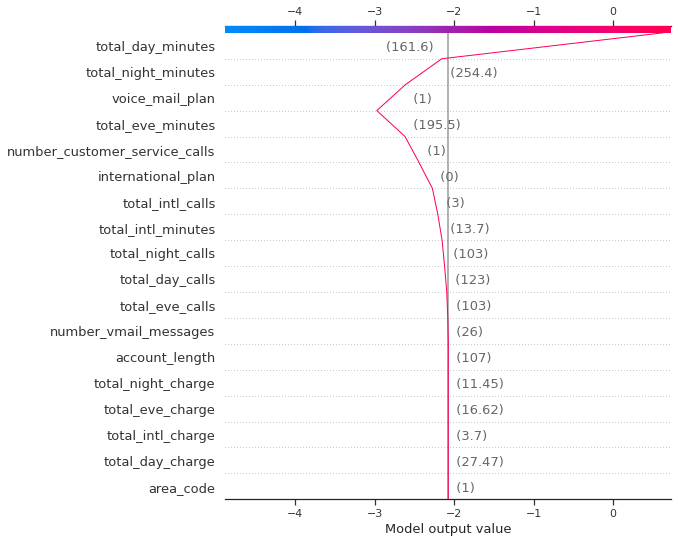

In [ ]:
shap.decision_plot(explainer.expected_value,
                   explainer.shap_values(X_train.iloc[4,:]),
                   X,
                   feature_names=X_train.columns.tolist()
                   )

In [ ]:
y_train[0:10]

2459    0
3767    0
3135    0
3028    0
1425    1
374     0
538     0
3690    1
3709    0
276     1
Name: churn, dtype: int64

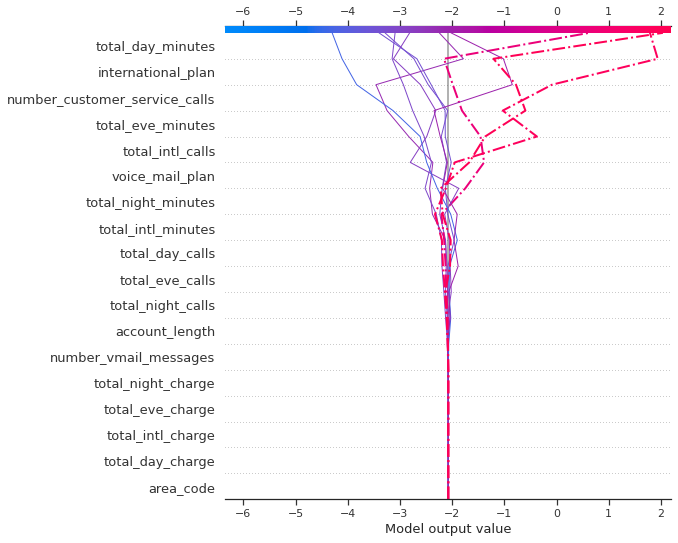

In [ ]:
shap.decision_plot(explainer.expected_value,
                   explainer.shap_values(X_train.iloc[0:10,:]),
                   feature_names=X_train.columns.tolist(),
                    highlight=[4, 7, 9],
                    # feature_order='hclust'
                   )

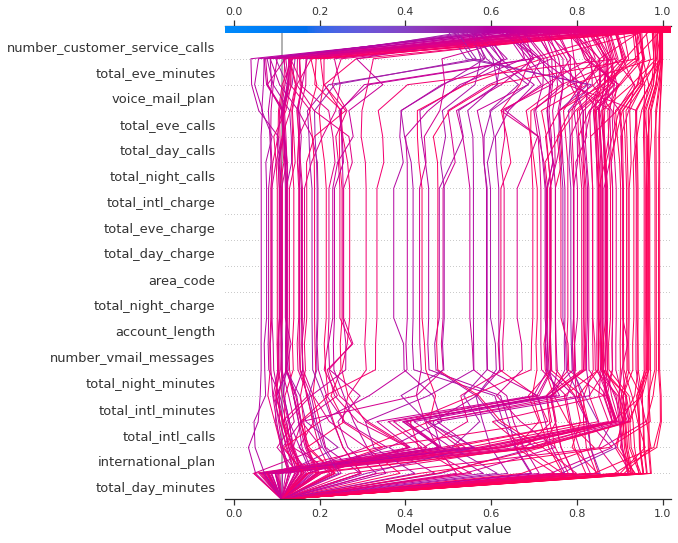

In [ ]:
y_pred = churnXGB.predict(X_test)
T = X_test[(y_pred == 1)]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
shap.decision_plot(explainer.expected_value, sh, T, feature_order='hclust', link='logit') 

#### Dependence plots
The partial dependence plot shows the marginal effect of one or two variables towards the predicted outcome. It indicate the relationship between the target and the variable whether its linear, monotonic, or more complex.

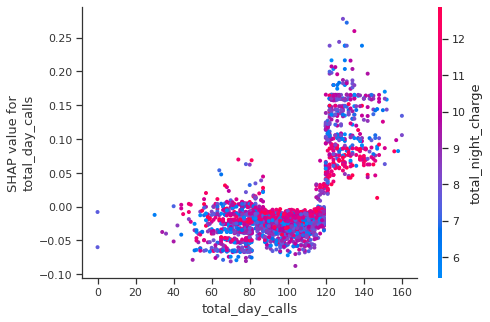

In [ ]:
shap.dependence_plot("total_day_calls", shap_values, X_train)

#### Collective force plot

The collective force plot shows show all the features that contribute toward the target prediction. This is the individual force plot stacked vertically across all the data points.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_train.iloc[:1000,:])